# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

План работы:  
1. Загрузка и подготовка данных
2. Обучение моделей
 - Бустинг модели
 - Не бустинг модели
3. Анализ моделей
4. Вывод

## Подготовка данных

### Импорт библиотек и данных, первичный просмотр

In [132]:
# !pip install catboost
# !pip install lightgbm
# !pip install ydata_profiling
# !pip install category_encoders

In [133]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt

from ydata_profiling import ProfileReport
from sklearn.metrics import mean_squared_error as mse

from category_encoders import TargetEncoder #для категориальных
from sklearn.preprocessing import StandardScaler #для числовых

from sklearn.model_selection import(
    train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV)

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

import warnings
warnings.filterwarnings('ignore')
rs = 112263

In [134]:
try:
    data = pd.read_csv('autos.csv')    
except:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/autos.csv')

In [135]:
df_raw = data.copy()

In [136]:
# ProfileReport(data)

### Предобработка данных

In [137]:
# Приведение названий столбцов в убобный для анализа вид
data.columns = data.columns.str.replace(r"([A-Z])", r" \1").str.lower().str.replace(' ', '_').str[1:]
data.columns

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type',
       'brand', 'repaired', 'date_created', 'number_of_pictures',
       'postal_code', 'last_seen'],
      dtype='object')

In [138]:
# Дроп значений, не влияющих на целевой показатель

data.drop(columns=['date_crawled', 'date_created', 'number_of_pictures',
                    'postal_code', 'last_seen', 'registration_month'], axis=1, inplace=True)

In [139]:
data.drop_duplicates(inplace=True)

In [140]:
print(f'Сумма дупликатов {df_raw.duplicated().sum()}')
display(df_raw[df_raw.duplicated(keep=False)])

Сумма дупликатов 4


,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
41529,2016-03-18 18:46:15,1999,wagon,2001,manual,131,passat,150000,7,gasoline,volkswagen,no,2016-03-18 00:00:00,0,36391,2016-03-18 18:46:15
88087,2016-03-08 18:42:48,1799,coupe,1999,auto,193,clk,20000,7,petrol,mercedes_benz,no,2016-03-08 00:00:00,0,89518,2016-03-09 09:46:57
90964,2016-03-28 00:56:10,1000,small,2002,manual,83,other,150000,1,petrol,suzuki,no,2016-03-28 00:00:00,0,66589,2016-03-28 08:46:21
171088,2016-03-08 18:42:48,1799,coupe,1999,auto,193,clk,20000,7,petrol,mercedes_benz,no,2016-03-08 00:00:00,0,89518,2016-03-09 09:46:57
187735,2016-04-03 09:01:15,4699,coupe,2003,auto,218,clk,125000,6,petrol,mercedes_benz,yes,2016-04-03 00:00:00,0,75196,2016-04-07 09:44:54
231258,2016-03-28 00:56:10,1000,small,2002,manual,83,other,150000,1,petrol,suzuki,no,2016-03-28 00:00:00,0,66589,2016-03-28 08:46:21
258109,2016-04-03 09:01:15,4699,coupe,2003,auto,218,clk,125000,6,petrol,mercedes_benz,yes,2016-04-03 00:00:00,0,75196,2016-04-07 09:44:54
325651,2016-03-18 18:46:15,1999,wagon,2001,manual,131,passat,150000,7,gasoline,volkswagen,no,2016-03-18 00:00:00,0,36391,2016-03-18 18:46:15


Пропуски решил заполнить значениями о умолчанию, поскольку заполнение средними или медианными значениями по группе или другим фильтрам могут исказить данные для дальнейшего обучения модели. 
При использовании такой модели обучения в приложении пользователя можно уведомить, что если какие то поля не заполнены,  это может отразиться на прогнозе цены, и такие пропуски могут быть заполнены значениями по умолчанию

In [141]:
# Обработка пропусков 

data.fillna({'gearbox':'manual', 'repaired':'no', 'model':'unknown', 'vehicle_type':'unknown', 'fuel_type':'unknown'}, inplace=True)
data.isna().mean()

price                0.0
vehicle_type         0.0
registration_year    0.0
gearbox              0.0
power                0.0
model                0.0
kilometer            0.0
fuel_type            0.0
brand                0.0
repaired             0.0
dtype: float64

In [142]:
data.price.value_counts()

0        8904
500      4650
1500     4533
1000     3875
1200     3799
         ... 
477         1
12560       1
15445       1
132         1
10985       1
Name: price, Length: 3731, dtype: int64

In [143]:
data.price.quantile([.05, 0.95])

0.05      200.0
0.95    14900.0
Name: price, dtype: float64

In [144]:
# Доля данных, где цена в диапазоне от 200 до 14900:
1 - data.query('200 <= price <= 14900').shape[0] / data.shape[0]

0.09725890556656502

In [145]:
# Дроп значений целевого рпизнака, где цена ниже 200 и выше 14900
data = data.query('200 <= price <= 14900')

In [146]:
data.power.describe()

count    279244.000000
mean        109.305718
std         200.372760
min           0.000000
25%          69.000000
50%         103.000000
75%         140.000000
max       20000.000000
Name: power, dtype: float64

<AxesSubplot:>

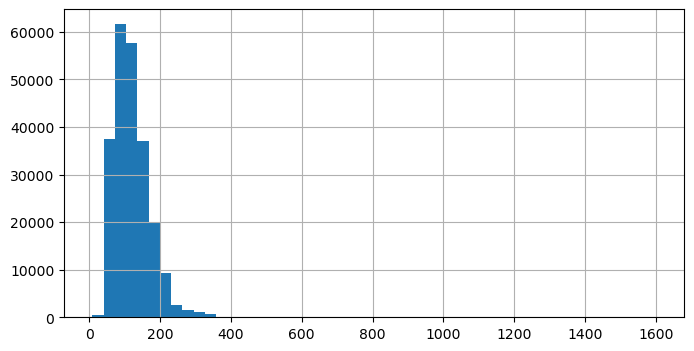

In [157]:
data.power.hist(bins=50, figsize=(8, 4))

In [148]:
data = data.query('9 <= power <= 1600')

In [149]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 248917 entries, 2 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              248917 non-null  int64 
 1   vehicle_type       248917 non-null  object
 2   registration_year  248917 non-null  int64 
 3   gearbox            248917 non-null  object
 4   power              248917 non-null  int64 
 5   model              248917 non-null  object
 6   kilometer          248917 non-null  int64 
 7   fuel_type          248917 non-null  object
 8   brand              248917 non-null  object
 9   repaired           248917 non-null  object
dtypes: int64(4), object(6)
memory usage: 20.9+ MB


In [150]:
data.describe()

,price,registration_year,power,kilometer
count,248917.000000,248917.000000,248917.000000,248917.000000
mean,4243.953462,2003.297300,118.726202,129415.246849
std,3646.112648,29.154592,57.789744,35679.040721
min,200.000000,1000.000000,9.000000,5000.000000
25%,1350.000000,1999.000000,75.000000,125000.000000
50%,2999.000000,2003.000000,110.000000,150000.000000
75%,6300.000000,2007.000000,143.000000,150000.000000
max,14900.000000,9999.000000,1600.000000,150000.000000


In [151]:
# Доля данных, где RegistrationYear до 2016 года:
print(f"% авто с регистрацией до 2016 года включительно: {(1 - df_raw.query('2016 <= RegistrationYear').shape[0] / df_raw.shape[0])*100}")
print(f"% авто с регистрацией после 2016 года          : {(1 - df_raw.query('2016 > RegistrationYear').shape[0] / df_raw.shape[0])*100}")

% авто с регистрацией до 2016 года включительно: 93.19099582638437
% авто с регистрацией после 2016 года          : 6.809004173615641


In [152]:
df_raw.RegistrationYear.quantile([.05, 0.95])

0.05    1992.0
0.95    2016.0
Name: RegistrationYear, dtype: float64

In [153]:
data = data.query('1992 <= registration_year <= 2016')

Корреляция признаков: 


,price,registration_year,power,kilometer
price,1.000000,0.594939,0.393882,-0.335082
registration_year,0.594939,1.000000,0.041837,-0.372411
power,0.393882,0.041837,1.000000,0.150714
kilometer,-0.335082,-0.372411,0.150714,1.000000


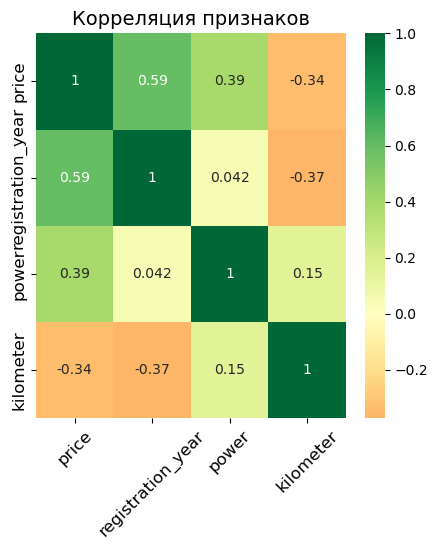

In [154]:
print('Корреляция признаков: ')
display(data.corr())

plt.figure(figsize=(5, 5))
sns.heatmap(data.corr(),
            xticklabels=data.corr().columns,
            yticklabels=data.corr().columns,
            cmap='RdYlGn',
            center=0,
            annot=True)

plt.title('Корреляция признаков', fontsize=14)
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)
plt.show()

Наблюдается умеренная корреляция между целевым признаком и мощностью авто, так же видна такая же умеренная отрицательная корреляция с пробегом, и незначительная связь с датой регистрации авто

In [155]:
print(f'% данных после обработки: {(data.shape[0]/df_raw.shape[0])*100}')
print(f'Кол-во записей: {data.shape[0]}')

% данных после обработки: 64.86459029994158
Кол-во записей: 229860


### Вывод по разделу

Были установлены и импортированы необходимве библиотеки и данные. Был проведен первичный анализ данных.  
Входе предобработки данных были устранены дупликаты, многие пропуски, а так же столбцы данных, не влияющих на целевой показатель - цену.  
Процент обучающих данных от исходных составил 64%, насчитывая порядка 230 тыс. записей, что является достаточным количеством

## Обучение моделей

In [91]:
# Подготовка признаков

features = data.drop('price', axis=1)
target = data.price

In [159]:
# Делим выборки на тренинг, валид и тест для линейной модели


features_train_ohe, features_valid_ohe, target_train, target_valid = train_test_split(
    features, target, test_size=.4, random_state=112263)

features_valid_ohe, features_test_ohe, target_valid, target_test = train_test_split(
     features_valid_ohe, target_valid, test_size=.5, random_state=112263)

# Размеры выборок
print(f'Размер обучающей выборки: {features_train_ohe.shape}')
print(f'Размер валид выборки: {features_valid_ohe.shape}')
print(f'Размер тестовой выборки: {features_test_ohe.shape}')

Размер обучающей выборки: (137916, 9)
Размер валид выборки: (45972, 9)
Размер тестовой выборки: (45972, 9)


In [93]:
# Подготовка признаков для линейной модели

features_train_ohe = pd.get_dummies(features_train_ohe, drop_first=True)
features_valid_ohe = pd.get_dummies(features_valid_ohe, drop_first=True)
features_test_ohe = pd.get_dummies(features_test_ohe, drop_first=True)

common_columns = set(features_train_ohe.columns) & set(features_valid_ohe.columns) & set(features_test_ohe.columns)

features_train_ohe = features_train_ohe[list(common_columns)]
features_valid_ohe = features_valid_ohe[list(common_columns)]
features_test_ohe = features_test_ohe[list(common_columns)]

In [94]:
# Делим выборки на тренинг и тест моделей для RandomizedSearchSV и GridSearchCV
train_data_cv, test_data_cv = train_test_split(data, test_size = 0.25, random_state = rs)

In [95]:
print(f'Размер обучающей выборки: {train_data_cv.shape}')
print(f'Размер тестовой выборки: {test_data_cv.shape}')

Размер обучающей выборки: (172395, 10)
Размер тестовой выборки: (57465, 10)


In [96]:
data.columns

Index(['price', 'vehicle_type', 'registration_year', 'gearbox', 'power',
       'model', 'kilometer', 'fuel_type', 'brand', 'repaired'],
      dtype='object')

In [97]:
categorial = ['vehicle_type','gearbox','model','fuel_type','brand','repaired']

Подготовка признаков данных и признаков дял нелинейных моделей

In [98]:
# Используем TargetEncoder для преобразования категориальных признаков

encoder = TargetEncoder()

train_data_cv[categorial] = encoder.fit_transform(train_data_cv[categorial], train_data_cv['price'])
test_data_cv[categorial] = encoder.fit_transform(test_data_cv[categorial], test_data_cv['price'])

train_features_cv = train_data_cv.drop(['price'], axis = 1)
train_target_cv = train_data_cv['price']

test_features_cv = test_data_cv.drop(['price'], axis = 1)
test_target_cv = test_data_cv['price']

In [99]:
display(train_data_cv.head(3))
display(test_data_cv.head(3))

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
92706,700,2965.937682,2001,3936.653452,90,3960.972114,150000,5858.096412,4031.231084,2153.784200
158028,1000,4493.734498,1999,3936.653452,116,3405.600927,125000,3730.323499,3203.559229,4549.701065
41008,6200,4493.734498,2003,5830.902743,177,5238.875334,150000,3730.323499,5250.311219,4549.701065


,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
124559,11000,4588.869754,2013,3951.25618,125,3365.251232,50000,3724.107324,3115.852273,4555.650313
142414,4990,4588.869754,1993,3951.25618,99,4834.755796,150000,3724.107324,5768.016480,4555.650313
199599,1000,2398.768739,2000,3951.25618,150,5758.454463,150000,2579.644478,5694.535370,4555.650313


Данные подготовлены для обучения моделей: выборки поделены, признаки обозначены

### Linear Regression

In [100]:
%%time

model_lr = LinearRegression()
model_lr.fit(features_train_ohe, target_train)

Wall time: 1.16 s


LinearRegression()

In [101]:
print('LinearRegression')
print('=='*25)
print('Модель обучена')
print(f'Время обучения модели:     1.18 s')

LinearRegression
Модель обучена
Время обучения модели:     1.18 s


### Decision Tree Regressor

In [102]:
%%time

# DecisionTreeRegressor + RandomizedSearchCV

 
model_dtr = DecisionTreeRegressor()
max_depth_list = [x for x in range(2, 10)]
min_samples_split_list = [x for x in range(2, 10)]
min_samples_leaf_list = [x for x in range(2, 10)]
parameters = [{
    'criterion':['mse'], 
    'max_depth':max_depth_list, 
    'min_samples_split':min_samples_split_list, 
    'min_samples_leaf':min_samples_leaf_list, 
    'random_state':[112263]}]

rscv = RandomizedSearchCV(model_dtr, parameters, scoring='neg_mean_squared_error')
rscv.fit(train_features_cv, train_target_cv)

print(rscv.best_params_)

mts = rscv.cv_results_['mean_test_score']

rmse_rscv_dtr = (max(mts) * -1) ** 0.5
rmse_rscv_dtr

{'random_state': 112263, 'min_samples_split': 6, 'min_samples_leaf': 5, 'max_depth': 9, 'criterion': 'mse'}
Wall time: 5.92 s


1619.3160172501605

In [103]:
# %%time

# # DecisionTreeRegressor + GridSearchCV
# Закоментировал по причине большого срока обучения ~5 min

# model_dtr = DecisionTreeRegressor() 
# max_depth_list = [x for x in range(2, 10)]
# min_samples_split_list = [x for x in range(2, 10)]
# min_samples_leaf_list = [x for x in range(2, 10)]
# parameters = [{
#     'criterion':['mse'], 
#     'max_depth':max_depth_list, 
#     'min_samples_split':min_samples_split_list, 
#     'min_samples_leaf':min_samples_leaf_list, 
#     'random_state':[112263]}]

# gscv = GridSearchCV(model_dtr, parameters, scoring='neg_mean_squared_error')
# for params in tqdm(parameters):
#     gscv.fit(train_features_cv, train_target_cv)

# print(gscv.best_params_)

# mts = gscv.cv_results_['mean_test_score']

# rmse_gscv_dtr = (max(mts) * -1) ** 0.5
# rmse_gscv_dtr

### Cat Boost Regressor

In [104]:
%%time

# CatBoostRegressor + RandomizedSearchCV
# Время выполнения кода порядка 2х минут


model_cbr = CatBoostRegressor()
# Добавлять гиперпараметр глубины не стал, поскольку даже с randomized search считалось неприлично долго
parameters = [{'learning_rate': [.1, .5, .9], 'random_state':[112263], 'verbose': [False]}]

rscv = RandomizedSearchCV(model_cbr, parameters, scoring='neg_mean_squared_error')
rscv.fit(train_features_cv, train_target_cv)

print(rscv.best_params_)

mts = rscv.cv_results_['mean_test_score']

rmse_cbr = (max(mts) * -1) ** 0.5
rmse_cbr

{'verbose': False, 'random_state': 112263, 'learning_rate': 0.5}
Wall time: 2min 11s


1299.3899159775833

In [105]:
# %%time

# # CatBoostRegressor + GridSearchCV
# # Время выполнения кода порядка 2х минут


# model_cbr = CatBoostRegressor() 
# Добавлять гиперпараметр глубины не стал, поскольку даже с randomized search считалось неприлично долго
# parameters = [{'learning_rate':[.1, .5, .9], 'random_state':[112263], 'verbose':[False]}]

# gscv = GridSearchCV(model_cbr, parameters, scoring='neg_mean_squared_error')
# # for params in tqdm(parameters):
# gscv.fit(train_features_cv, train_target_cv)

# print(gscv.best_params_)

# mts = gscv.cv_results_['mean_test_score']
    
# rmse_cbr = (max(mts) * -1) ** 0.5
# rmse_cbr

### LGBMRegressor

In [106]:
%%time

# LGBMRegressor + RandomizedSearchCV
# Время выполнения кода порядка одной минуты


model_lgbmr = LGBMRegressor() 
parameters = [{'learning_rate': [.1, .5, .9], 'num_leaves':[50, 100, 200],'random_state':[112263]}]

rscv = RandomizedSearchCV(model_lgbmr, parameters, scoring='neg_mean_squared_error')
rscv.fit(train_features_cv, train_target_cv)

print(rscv.best_params_)

mts = rscv.cv_results_['mean_test_score']

rmse_lgbmr = (max(mts) * -1) ** 0.5
rmse_lgbmr

{'random_state': 112263, 'num_leaves': 200, 'learning_rate': 0.1}
Wall time: 43.5 s


1293.9747425321298

In [107]:
# %%time

# # LGBMRegressor + GridSearchCV
# # Время выполнения кода порядка одной минуты


# model_lgbmr = LGBMRegressor() 
# parameters = [{'learning_rate':[.1, .5, .9], 'num_leaves':[50, 100, 200], 'random_state':[112263]}]

# gscv = GridSearchCV(model_lgbmr, parameters, scoring='neg_mean_squared_error')
# # for params in tqdm(parameters):
# gscv.fit(features_train, target_train)

# print(gscv.best_params_)
# print()

# mts = gscv.cv_results_['mean_test_score']

# rmse_lgbmr = (max(mts) * -1) ** 0.5
# rmse_lgbmr

## Анализ моделей

В качестве анализа моделей будет произведен поиск оптимальных гиперпараметров посредством RandomizedSearchCV, по итогам оценки всех моделей, составим рейтинг моделей и выберем с лучшую. Далее с полученными гиперпараметрами проверим модель та тестовой выборке

### Linear Regression

In [108]:
%%time

model_lr = LinearRegression()
model_lr.fit(features_train_ohe, target_train)

Wall time: 1.32 s


LinearRegression()

In [109]:
%%time

# Подсчет RMSE на валидной выборке


target_predict = model_lr.predict(features_valid_ohe)

rmse_lr_valid = mse(target_valid, target_predict) ** 0.5
print(f'RMSE Linear Regression: {rmse_lr_valid}')

RMSE Linear Regression: 1956.3151922569632
Wall time: 64.2 ms


In [110]:
print('LinearRegression')
print('=='*25)
print(f'Время обучения модели:     0.978 s')
print(f'Время предсказания модели: 0.634 s')
print(f'RMSE модели:               {rmse_lr_valid.round(0)}')

LinearRegression
Время обучения модели:     0.978 s
Время предсказания модели: 0.634 s
RMSE модели:               1956.0


### Decision Tree Regressor

In [111]:
# %%time
# # 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_depth': 9, 'criterion': 'mse'
# # Рассчет времени и RMSE на кросс валидации


# model_dtr = DecisionTreeRegressor(max_depth=9, min_samples_leaf=3,min_samples_split=4, random_state=rs)
# model_dtr.fit(train_features_cv, train_target_cv)

In [112]:
# %%time

# target_predict = model_dtr.predict(train_features_cv)
# rmse_dtr_cv = mse(train_target_cv, target_predict) ** 0.5
# rmse_dtr_cv

In [113]:
%%time

parameters = [{'min_samples_split': [3], 'min_samples_leaf': [9], 'max_depth': [9],'random_state':[112263]}]
rscv = RandomizedSearchCV(model_dtr, parameters, scoring='neg_mean_squared_error')
rscv.fit(train_features_cv, train_target_cv);

mts = rscv.cv_results_['mean_test_score']

rmse_dtr_cv = (max(mts) * -1) ** 0.5

Wall time: 1.08 s


In [114]:
%%time
rscv.predict(train_features_cv);

Wall time: 15.7 ms


array([1393.34433594, 1768.36050725, 4632.92330097, ..., 1103.80438402,
       1258.72769671, 4944.9683819 ])

In [115]:
print('DecisionTreeRegressor')
print('=='*25)
print(f'При лучших гиперпараметрах: \n{rscv.best_params_}')
print('=='*25)
print(f'Время обучения модели:     1.04 s')
print(f'Время предсказания модели: 0.015 s')
print(f'RMSE модели:               {rmse_dtr_cv.round(0)}')

DecisionTreeRegressor
При лучших гиперпараметрах: 
{'random_state': 112263, 'min_samples_split': 3, 'min_samples_leaf': 9, 'max_depth': 9}
Время обучения модели:     1.04 s
Время предсказания модели: 0.015 s
RMSE модели:               1619.0


### CatBoost Regressor

In [116]:
%%time

# {'verbose': False, 'random_state': 112263, 'learning_rate': 0.5}
# Рассчет времени и RMSE на кросс валидации

# model_cbr = CatBoostRegressor(learning_rate=0.5, verbose=False, random_state=rs)
# model_cbr.fit(train_features_cv, train_target_cv)

Wall time: 0 ns


In [117]:
# %%time

# target_predict = model_cbr.predict(train_features_cv)
# rmse_cbr_cv = mse(train_target_cv, target_predict) ** 0.5
# rmse_cbr_cv

In [118]:
%%time

parameters = [{'learning_rate': [.5,], 'verbose': [False],'random_state':[112263]}]
rscv = RandomizedSearchCV(model_cbr, parameters, scoring='neg_mean_squared_error')
rscv.fit(train_features_cv, train_target_cv);

mts = rscv.cv_results_['mean_test_score']

rmse_cbr_cv = (max(mts) * -1) ** 0.5

Wall time: 50.8 s


In [119]:
%%time
rscv.predict(train_features_cv);

Wall time: 35.3 ms


array([ 770.05365036, 1451.61240392, 6534.6979378 , ..., 1525.1547676 ,
       1022.20467096, 4836.82046379])

In [120]:
print('CatBoostRegressor')
print('=='*25)
print(f'При лучших гиперпараметрах: \n{rscv.best_params_}')
print('=='*25)
print(f'Время обучения модели:     49.5 s')
print(f'Время предсказания модели: 0.032 s')
print(f'RMSE модели:               {rmse_cbr_cv.round(0)}')

CatBoostRegressor
При лучших гиперпараметрах: 
{'verbose': False, 'random_state': 112263, 'learning_rate': 0.5}
Время обучения модели:     49.5 s
Время предсказания модели: 0.032 s
RMSE модели:               1299.0


### LGBMRegressor

In [121]:
# %%time

# {'random_state': 112263, 'num_leaves': 200, 'learning_rate': 0.1}
# Рассчет времени и RMSE на кросс валидации


# model_lgbmr = LGBMRegressor(learning_rate=0.1, num_leaves=200, random_state=rs)
# model_lgbmr.fit(train_features_cv, train_target_cv)

In [122]:
# %%time

# target_predict = model_lgbmr.predict(train_features_cv)
# rmse_lgbmr_cv = mse(train_target_cv, target_predict) ** 0.5
# rmse_lgbmr_cv

In [123]:
%%time

parameters = [{'learning_rate': [.1], 'num_leaves':[200],'random_state':[112263]}]
rscv = RandomizedSearchCV(model_lgbmr, parameters, scoring='neg_mean_squared_error')
rscv.fit(train_features_cv, train_target_cv);

mts = rscv.cv_results_['mean_test_score']

rmse_lgbmr_cv = (max(mts) * -1) ** 0.5

Wall time: 9.44 s


In [124]:
%%time
rscv.predict(train_features_cv);

Wall time: 153 ms


array([1070.97072729, 1502.91568299, 6401.42452566, ..., 1385.69369938,
       1091.43974735, 5102.11889075])

In [125]:
print('LGBMRegressor')
print('=='*25)
print(f'При лучших гиперпараметрах: \n{rscv.best_params_}')
print('=='*25)
print(f'Время обучения модели:     9.21 s')
print(f'Время предсказания модели: 0.142 s')
print(f'RMSE модели:               {rmse_lgbmr_cv.round(0)}')

LGBMRegressor
При лучших гиперпараметрах: 
{'random_state': 112263, 'num_leaves': 200, 'learning_rate': 0.1}
Время обучения модели:     9.21 s
Время предсказания модели: 0.142 s
RMSE модели:               1294.0


In [126]:
# Сводный датафрейм рейтинга моделей с учетом равных критериев к отбору по скорости обучения, предсказания и точности


index = ['LinearRegression',
         'DecisionTreeRegressor',
         'CatBoostRegressor',
         'LGBMRegressor']

data = {'RMSE': [rmse_lr_valid, rmse_dtr_cv, rmse_cbr_cv, rmse_lgbmr_cv],
        'fit time': [0.978, 1.04, 49.5, 9.21],        
        'predict time': [0.634, 0.015, 0.032, 0.142]}

# Вес критериев равный
rating = pd.DataFrame(data=data, index=index)
rating['rating'] = (rating['RMSE'] * 0.34 \
                       + rating['fit time'] * 0.33 \
                       + rating['predict time'] * 0.33)

rating.sort_values(by='rating')

,RMSE,fit time,predict time,rating
LGBMRegressor,1293.974743,9.210,0.142,443.037572
CatBoostRegressor,1299.389916,49.500,0.032,458.138131
DecisionTreeRegressor,1618.797928,1.040,0.015,550.739446
LinearRegression,1956.315192,0.978,0.634,665.679125


***Переписать выводы и коментарии к изменениям***

Модель `LGBMRegressor` показала наилучший результат среду других прочих моделей по скорости обучния и предсказаниях на кроссвалидации - `9.21 и 0.142 секунды` соответственно, `RMSE модели составил 1293`

## Тестирование лучшей модели

In [127]:
%%time

parameters = [{'learning_rate': [.1], 'num_leaves':[200],'random_state':[112263]}]
rscv = RandomizedSearchCV(model_lgbmr, parameters, scoring='neg_mean_squared_error')
rscv.fit(train_features_cv, train_target_cv);

mts = rscv.cv_results_['mean_test_score']

rmse_lgbmr_test = (max(mts) * -1) ** 0.5

Wall time: 9.65 s


In [128]:
%%time
rscv.predict(test_features_cv);

Wall time: 68 ms


array([13089.19450794,   911.1352648 ,  1604.16891371, ...,
         603.80099779, 10095.62533268,  4038.03146611])

In [129]:
print('LGBMRegressor')
print('=='*25)
print(f'При лучших гиперпараметрах: \n{rscv.best_params_}')
print('=='*25)
print(f'Время обучения модели:     9.27 s')
print(f'Время предсказания модели: 0.073 s')
print(f'RMSE модели:               {rmse_lgbmr_test.round(0)}')

LGBMRegressor
При лучших гиперпараметрах: 
{'random_state': 112263, 'num_leaves': 200, 'learning_rate': 0.1}
Время обучения модели:     9.27 s
Время предсказания модели: 0.073 s
RMSE модели:               1294.0


## Вывод

Была проведена работа по разработке модели, которая умеет определять рыночную стоимость автомобиля на основе данные о технических характеристиках, комплектации и ценах автомобилей.

Важными критериями к модели были обозначены `качество предсказания, время обучения и время предсказания.`

В ходе предобработки данных были устранены дупликаты, некоторые пропуски, данные, не влияющие на показатель цены. Процент обучающих данных от исходных составил 64%, насчитывая порядка `230 тыс. записей`, что является достаточным количеством

По итогам качества и скорости обучения на тестовых данных победила модель `LightGBM (RMSE: 1294)`при скорости обучения и предсказании модели за `9.27 и 0.073 секунды` соответственно.

Таким образом смело можно рекомендовать модель LGBMRegressor, так как при лучшием показателяе RMSE, модель достигает результата с значительно меньшими времеными затратами